In [1]:
import numpy as np
from PIL import Image
import cv2
import glob
from scipy import interpolate
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt
import os
from pathlib import Path

from ripser import ripser 
from persim import plot_diagrams
from sklearn.decomposition import PCA

#topological data analysis
from persim import plot_diagrams
from dreimac import CircularCoords 
from dreimac import CircleMapUtils as CMU

#plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

In [2]:
# Auxiliary video functions
def getSlidingWindowVideo(I, dim, Tau, dT):
    N = I.shape[0] #Number of frames
    P = I.shape[1] #Number of pixels (possibly after PCA)
    pix = np.arange(P)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    X = np.zeros((NWindows, dim*P))
    idx = np.arange(N)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))
        f = interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
        X[i, :] = f(pix, idxx).flatten()
    return X

def writeVideo(filename, frame_data, fps, resol ):
    n_row, n_col = resol
    out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (n_col, n_row))
    if frame_data.dtype !='uint8':
        frame_data -= np.amin(frame_data)
        frame_data *= 255/np.amax(frame_data)
        frame_data = np.uint8(frame_data)
    for frame in frame_data:
        out.write(frame.reshape((n_row, n_col,-1)))
    out.release()

def playVideo(filepath):
    cap = cv2.VideoCapture(filepath)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('frame', frame)
        if cv2.waitKey(24) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()  

def loadVideo(filepath):
    vid = cv2.VideoCapture(filepath)
    _, image = vid.read()
    count = 0
    success = True
    n_row, n_col, _ = image.shape
    data = []
    while success:
        data.append(image.flatten()) 
        success,image = vid.read()
        count += 1
    vid.release() 
    data = np.array(data)
    print(count, " frames extracted")
    print("frame size = ", (n_row , n_col))
    print("data shape =", data.shape)
    return data , (n_row, n_col)

In [3]:
data , shape = loadVideo('dots_quasi.wmv')
#n_row, n_col = shape

390  frames extracted
frame size =  (100, 200)
data shape = (390, 60000)


In [133]:
wSize = 18
dim = 5
Tau = wSize/float(dim)

desiredSamples = 1000
M = data.shape[0] - wSize + 1
dT = M/float(desiredSamples)

SW_video = getSlidingWindowVideo(data, dim, Tau, dT)

/var/folders/2f/76h8xtxd6yn1mn8rfx554nth0000gn/T/ipykernel_30143/1842224043.py:13: DeprecationWarning:

`interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`


/var/folders/2f/76h8xtxd6yn1mn8rfx554nth0000gn/T/ipykernel_30143/1842224043.py:14: DeprecationWarning:

        `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

In [5]:
#SW_video.shape

(997, 180000)

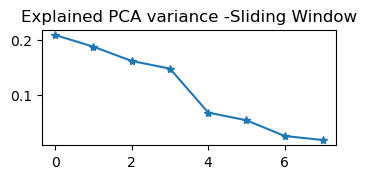

In [134]:
# PCA of the Sliding window point cloud
pca = PCA(n_components=8)
SW_pca = pca.fit(SW_video).transform(SW_video)
plt.figure(figsize = (3.8,1.5))
plt.plot(pca.explained_variance_ratio_, '-*') ;
plt.title('Explained PCA variance -Sliding Window');

In [135]:
#Task 1 Torus
fig = go.Figure(data=[go.Scatter3d(
    x=SW_pca[:,0], y=SW_pca[:,1], z=SW_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 2.5, color = 'brown')
)] , layout = go.Layout(scene = dict(aspectmode= 'data')))

fig.show()

In [136]:
# Get the circular coordinates at birth, and for the 2 cocycles with highest persistence
coho_classes = [0, 1]

circular_coords = []

n_lands = 200

cc = CircularCoords(SW_pca, n_landmarks=n_lands)

for i in coho_classes:
    theta = cc.get_coordinates(perc=0, cocycle_idx=i)
    theta = CMU.to_sinebow(np.pi + CMU.center(theta))
    circular_coords.append(theta)

In [137]:
#Show the cc of the 2 oscillators
fig = make_subplots(rows=1, cols=len(coho_classes), 
                    subplot_titles = tuple('Circ Coord '+str(i+1) for i in coho_classes),
                    specs = [[{'type': 'scatter3d'} for i in coho_classes]])

for i, coord in enumerate(circular_coords):
    fig.add_trace(
        go.Scatter3d(x=SW_pca.T[0], y=SW_pca.T[1], z=SW_pca.T[2],   mode ='markers', 
        marker=dict(size = 2 , color = circular_coords[i])),  
        row=1, col=i+1)
    fig.update_scenes(xaxis=dict( ticks='', showticklabels=False), 
                      yaxis=dict( ticks='', showticklabels=False), 
                      zaxis=dict( ticks='', showticklabels=False), 
                      aspectmode='data', row=1, col=i+1)

fig.update_layout( showlegend=False )
fig.show()

In [138]:
theta_1=[]
for coords in circular_coords[0]:
    angle=np.arctan2(coords[1], coords[0])
    theta_1.append(angle)
    
theta_2=[]
for coords in circular_coords[1]:
    angle=np.arctan2(coords[1], coords[0])
    theta_2.append(angle)

In [139]:
theta_1 = np.array(theta_1)
theta_2 = np.array(theta_2)

In [87]:
#len(theta_1)

In [140]:
#change (#,1) depending on desired sample
osc1 = np.reshape(theta_1, (997,1))
osc2 = np.reshape(theta_2, (997,1))

In [141]:
# Get the shape of the matrices
m1_rows, m1_cols = osc1.shape
m2_rows, m2_cols = osc2.shape

# Create indices for all possible pairs
rows, cols = np.meshgrid(np.arange(m1_rows), np.arange(m1_cols))

# Reshape the indices for pairing
indices = np.column_stack((rows.flatten(), cols.flatten()))

# Pair the elements from both matrices using the indices
angle_pairs = np.column_stack((osc1[indices[:, 0], indices[:, 1]].flatten(), osc2.flatten()))

In [46]:
#angle_pairs[0]

In [142]:
#Extract the columns from the matrix
col1 = angle_pairs[:, 0]
col2 = angle_pairs[:, 1]

# Sort the matrices based on the respective column
sorted_indices_1 = np.argsort(col1)
sorted_m1 = angle_pairs[sorted_indices_1]

sorted_indices_2 = np.argsort(col2)
sorted_m2 = angle_pairs[sorted_indices_2]

In [48]:
# Print the sorted matrices
#sorted_m1
#sorted_m2[0]

In [143]:
#Get the original indices for each element
original_indices = np.arange(angle_pairs.shape[0])

# Get the new indices after sorting
new_indices_1 = np.argsort(sorted_indices_1)
new_indices_2 = np.argsort(sorted_indices_2)

In [144]:
 # Print the sorted matrix with corresponding original and new indices
for i in range(angle_pairs.shape[0]):
    sorted_row = sorted_m1[i]
    original_index = original_indices[i]
    new_index = sorted_indices_1[i]
    print(f"Original Index: {original_index}, New Index: {new_index}, Sorted Row: {sorted_row}")

Original Index: 0, New Index: 490, Sorted Row: [3.82858774e-07 6.29041504e-04]
Original Index: 1, New Index: 625, Sorted Row: [1.89889125e-05 2.03485991e-01]
Original Index: 2, New Index: 851, Sorted Row: [2.43895408e-05 1.24316708e+00]
Original Index: 3, New Index: 265, Sorted Row: [6.63949460e-05 1.45682799e+00]
Original Index: 4, New Index: 580, Sorted Row: [8.62704398e-05 1.38470041e-01]
Original Index: 5, New Index: 130, Sorted Row: [1.29003477e-04 1.56111272e+00]
Original Index: 6, New Index: 984, Sorted Row: [3.53137363e-04 1.50024263e+00]
Original Index: 7, New Index: 175, Sorted Row: [4.72427365e-04 1.57032491e+00]
Original Index: 8, New Index: 176, Sorted Row: [8.73251842e-04 1.56886838e+00]
Original Index: 9, New Index: 669, Sorted Row: [0.00114666 0.25152839]
Original Index: 10, New Index: 806, Sorted Row: [0.00116826 0.8939809 ]
Original Index: 11, New Index: 895, Sorted Row: [1.20861239e-03 1.26998145e+00]
Original Index: 12, New Index: 670, Sorted Row: [0.00124429 0.2804

In [145]:
 # Print the sorted matrix with corresponding original and new indices
for i in range(angle_pairs.shape[0]):
    sorted_row = sorted_m2[i]
    original_index = original_indices[i]
    new_index = sorted_indices_2[i]
    print(f"Original Index: {original_index}, New Index: {new_index}, Sorted Row: {sorted_row}")

Original Index: 0, New Index: 489, Sorted Row: [5.11389592e-02 6.64381120e-06]
Original Index: 1, New Index: 190, Sorted Row: [8.55001400e-01 1.09916369e-05]
Original Index: 2, New Index: 532, Sorted Row: [1.98609840e-01 4.05230119e-05]
Original Index: 3, New Index: 746, Sorted Row: [1.56020757e+00 1.07715213e-04]
Original Index: 4, New Index: 961, Sorted Row: [1.35852886e+00 1.55522798e-04]
Original Index: 5, New Index: 104, Sorted Row: [1.18919528e+00 1.61763174e-04]
Original Index: 6, New Index: 446, Sorted Row: [0.00216918 0.00017198]
Original Index: 7, New Index: 618, Sorted Row: [8.90667560e-01 2.12352225e-04]
Original Index: 8, New Index: 147, Sorted Row: [9.57335439e-01 2.20116276e-04]
Original Index: 9, New Index: 575, Sorted Row: [5.78802893e-01 4.31268998e-04]
Original Index: 10, New Index: 445, Sorted Row: [0.0277989 0.0005167]
Original Index: 11, New Index: 319, Sorted Row: [0.33000123 0.00062226]
Original Index: 12, New Index: 490, Sorted Row: [3.82858774e-07 6.29041504e-

In [146]:
idx1 = np.array(sorted_indices_1)
idx2 = np.array(sorted_indices_2)

In [147]:
SW_sort1 = SW_video[idx1]
SW_sort2 = SW_video[idx2]

In [54]:
#SW_sort1.shape
#SW_sort2.shape

In [23]:
first_elements=[]
for frame in SW_sort1:
    list=[] 
    for j in range(60000):
        list.append(frame[i])
    first_elements.append(list)

In [29]:
first_elements = np.array(first_elements)

In [55]:
#Michael's code cont. Takes too long to run
#chunksize = 3
#final_lists=[]
#for j in range(len(first_elements)):
    #sublists = [first_elements[j][i:i+chunksize] for i in range(0, len(first_elements[j]), chunksize)]
    #final_lists.append(sublists)
#final_lists=np.array(final_lists)

In [79]:
#This gives the right shape but a grey screen only video
sorted_matrix = SW_sort1

# Parameters
num_windows = sorted_matrix.shape[0]
total_elements = sorted_matrix.shape[1]
row_size = 20000
overlap_size = row_size // 2

# Compute the number of groups per row
groups_per_row = int((total_elements - overlap_size) / (row_size - overlap_size))

# Calculate the number of elements to append in the new matrix
num_elements = num_windows * row_size

# Create a new matrix for the averaged RGB values
vid_matrix = np.zeros((num_windows, row_size, 3), dtype=np.uint8)

# Iterate over each window
for i in range(num_windows):
    # Iterate over each group in the row
    for j in range(groups_per_row):
        # Compute the start index of the current group
        start_index = j * (row_size - overlap_size)
    
        # Compute the end index of the current group
        end_index = start_index + row_size

        # Get the corresponding region from the current window
        region = sorted_matrix[i, start_index:end_index]

        # Reshape the region to (group_size, 1) for easier calculations
        region = np.reshape(region, (row_size, 1))

        # Compute the average of the region
        averaged_value = np.mean(region)

        # Expand the averaged value to RGB format
        averaged_rgb = np.full((row_size, 3), averaged_value, dtype=np.uint8)

        # Store the averaged RGB values in the new matrix
        vid_matrix[i, :, :] = averaged_rgb

    # Reshape the new matrix to have the desired shape
    vid_matrix = np.reshape(vid_matrix, (num_windows, row_size, 3))

# Print the new matrix shape
#print(vid_matrix.shape)

In [57]:
#still gives only grey screen
sorted_matrix = SW_sort1

# Parameters
num_windows = sorted_matrix.shape[0]
total_elements = sorted_matrix.shape[1]
group_size = 20000
overlap_size = group_size // 2

# Compute the number of groups per row
groups_per_row = int((total_elements - overlap_size) / (group_size - overlap_size))

# Calculate the number of elements to append in the new matrix
num_elements = num_windows * group_size

# Create a new matrix for the averaged RGB values
new_matrix = np.zeros((num_windows, group_size, 3), dtype=np.uint8)

# Initialize the index for appending values in the new matrix
new_matrix_index = 0

# Iterate over each window
for i in range(num_windows):
    # Iterate over each group in the row
    for j in range(groups_per_row):
        # Compute the start index of the current group
        start_index = j * (group_size - overlap_size)

        # Compute the end index of the current group
        end_index = start_index + group_size
        
        # Get the corresponding region from the current window
        region = sorted_matrix[i, start_index:end_index]

        # Reshape the region to (group_size, 1) for easier calculations
        region = np.reshape(region, (group_size, 1))
        
        # Compute the average of the region
        averaged_value = np.mean(region)

        # Expand the averaged value to RGB format
        averaged_rgb = np.full((group_size, 3), averaged_value, dtype=np.uint8)

        # Compute the start index for appending in the new matrix
        append_start_index = new_matrix_index

        # Compute the end index for appending in the new matrix
        append_end_index = new_matrix_index + group_size

        # Append the averaged RGB values to the new matrix
        new_matrix[i, :, :] = averaged_rgb

        # Update the index for appending values in the new matrix
        new_matrix_index = append_end_index

    # Resize the new matrix to have the desired shape
    new_matrix = new_matrix[:, :new_matrix_index, :]

# Print the new matrix shape
#print(new_matrix.shape)

In [ ]:
#This gives slightly better result (using Michael's code as template for chatGPT) but the left dot still moves wonky
#It be still a lil tho!!!

first_elements = []
overlap_indices = []

for i in range(len(SW_video)):
    sublist = []
    overlap_flag = False
    for j in range(len(SW_sort1[i])):
        sublist.append(SW_sort1[i][j])
        if not overlap_flag:
            if sublist.count(SW_sort1[i][j]) > 1:
                overlap_indices.append(j)
                overlap_flag = True
    first_elements.append(sublist)
        
# Find the index where the overlapping elements end
overlap_end = max(overlap_indices)

# Calculate the average of the overlapping elements
overlap_avg = np.mean([sublist[:overlap_end] for sublist in first_elements], axis=0)

# Iterate over each sublist and replace the overlapping elements with the average
for sublist in first_elements:
    sublist[:overlap_end] = overlap_avg
    
# Create fl as a list with each row containing 20,000 sub-sublists of size 3
fl = []
for sublist in first_elements:
    sublist_chunks = [sublist[i:i+3] for i in range(0, len(sublist), 3)]
    fl.extend(sublist_chunks[:20000])

# Reshape fl to have the desired shape (*depends on desired samples*, 20000, 3)
fl_reshaped = np.array(fl).reshape((997, 20000, 3))

# Verify the shape of fl_reshaped
print(fl_reshaped.shape)  # Output: (*depends on desired samples*, 20000, 3)

In [28]:
#need to freeze one of the oscillators instead of taking info of both. idk how tho

In [97]:
#writeVideo('test.wmv', fl_reshaped, 25, (100, 200))

In [149]:
playVideo('test.wmv')

In [131]:
#writeVideo('test1.wmv', fl_reshaped, 25, (100, 200))

In [150]:
playVideo('test1.wmv')

In [ ]:
writeVideo('test2.wmv', fl_reshaped, 25, (100, 200))

In [ ]:
playVideo('test2.wmv')